In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

import numpy as np

from learning_utilities import *

In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [4]:
# structures = ['7N', '12N']
# labels_to_sample = structures + map(convert_to_surround_name, structures)
# labels_to_sample = structures + [convert_to_surround_name(l, surr_l) for l in structures for surr_l in structures + ['noclass'] if surr_l != l]
# labels_to_sample = structures + [l + '_negative' for l in structures]
labels_to_sample = structures + [l + '_negative' for l in structures] + \
[convert_to_surround_name(l, margin=m, suffix=surr_l) for m in [100,200,300,400,500,600,700,800,900,1000]
 for l in structures for surr_l in structures + ['noclass'] if surr_l != l] + \
['noclass']

In [6]:
# Optional, if no need to sample training patches

labels = set([])

# for stack in ['MD589', 'MD585', 'MD594']:
for stack in ['MD635']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack

In [7]:
existing_names = set([convert_to_original_name(l) for l in labels]) - {'noclass'}

# Load pre-computed svm classifiers

In [47]:
train_sample_scheme = 2

In [48]:
svc_allClasses = {}
# for label in structures:
for label in existing_names:
    if stack in ['MD635']: # neurotrace blue stacks
        svc_allClasses[label] = joblib.load(SVM_NTBLUE_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})
    else: # regular Nissl
        svc_allClasses[label] = joblib.load(SVM_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

# Test

In [9]:
if stack in ['MD635']:
    test_feat_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'test_features'))
else:
    test_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'test_features'))

# Sample test features

In [ ]:
test_addresses = defaultdict(list)

# for stack in ['MD589', 'MD585', 'MD594']:
for stack in ['MD635']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    sampled_addresses_sec_idx = sample_locations(label_gridIndices, labels, num_samples_per_landmark=1000)
    
    for name_u, addresses in sampled_addresses_sec_idx.iteritems():
        test_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
test_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

In [ ]:
test_features = apply_function_to_dict(addresses_to_features, test_addresses)

In [ ]:
test_features = {name: np.array([f for f in feats if f is not None]) for name, feats in test_features.iteritems()}

In [ ]:
# Save test features

for name_u, feats in test_features.iteritems():
#     bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, name_u + '_trainSampleScheme_%d.bp' % train_sample_scheme))
    bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, name_u + '.bp'))

# .. or load pre-saved test features

In [10]:
# test_features = {name: bp.unpack_ndarray_file(os.path.join(test_feat_dir, name + '_trainSampleScheme_%d.bp' % train_sample_scheme)) for name in labels}
test_features = {name: bp.unpack_ndarray_file(os.path.join(test_feat_dir, name + '.bp')) for name in labels}

# Analyze performance

In [18]:
if stack in ['MD635']:
    plots_dir = create_if_not_exists(os.path.join(SVM_NTBLUE_ROOTDIR, 'plots'))
else:
    plots_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'plots'))

# Compute x vs. all negative accuracy

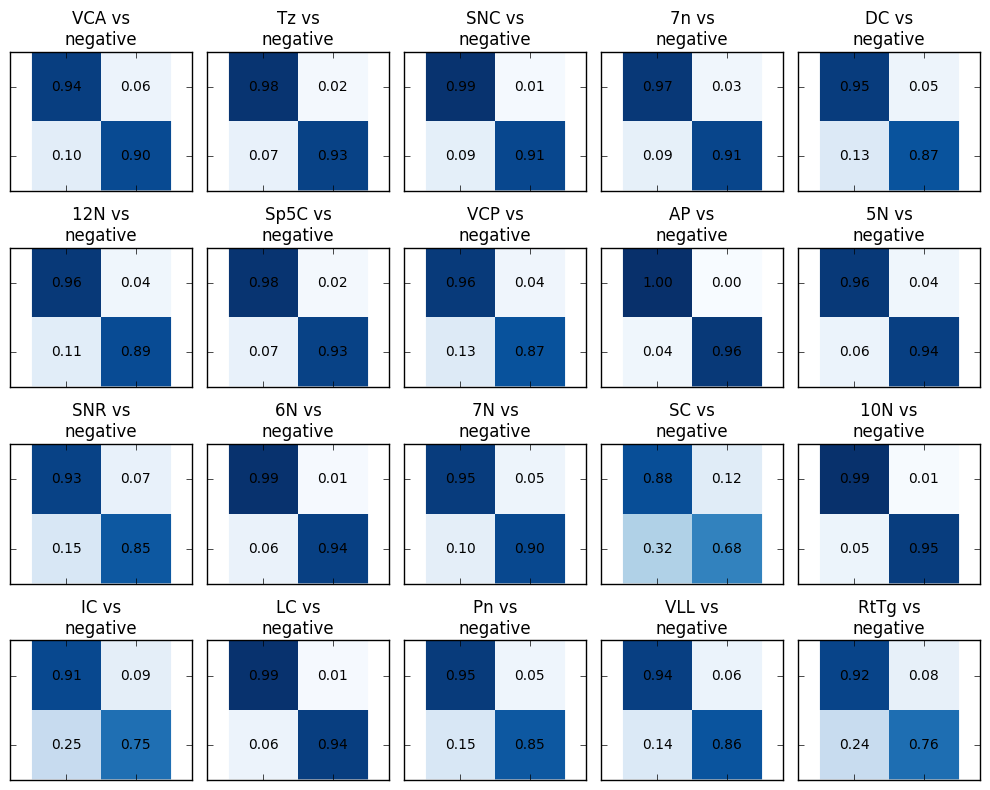

In [14]:
# Compute x vs. all negative accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))


fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = test_features[label]
    n_pos = len(features_pos)
    
#     features_neg = test_features[convert_to_surround_name(label)]
    
#     if train_sample_scheme in [1,3,4,5,6,7]:
#         features_neg = test_features[convert_to_surround_name(label, 'noclass')]
#     elif train_sample_scheme == 2:
#         features_neg = np.vstack([test_features[convert_to_surround_name(label, 'noclass')]] + \
#                                   [test_features[convert_to_surround_name(label, surr_l)] 
#                                   for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
# #     elif train_sample_scheme == 8:
    features_neg = test_features[label + '_negative']
    n_neg = len(features_neg)
#         features_neg = test_features['7N']
#     else:
#         sys.stderr.write('training scheme is not recognized.\n')
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    plot_confusion_matrix(cm, title='%(label)s vs\nnegative'% {'label':label},
                          labels=['',''], xlabel='', ylabel='',
                         axis=axes[i])
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc
    
plt.tight_layout()

In [ ]:
print 'test accuracy:', np.mean(acc_all_structures.values())

In [ ]:
single_vs_negative_cm_plot_fp = os.path.join(plots_dir, 'single_vs_negative_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

# Compute x vs. noclass accuracy

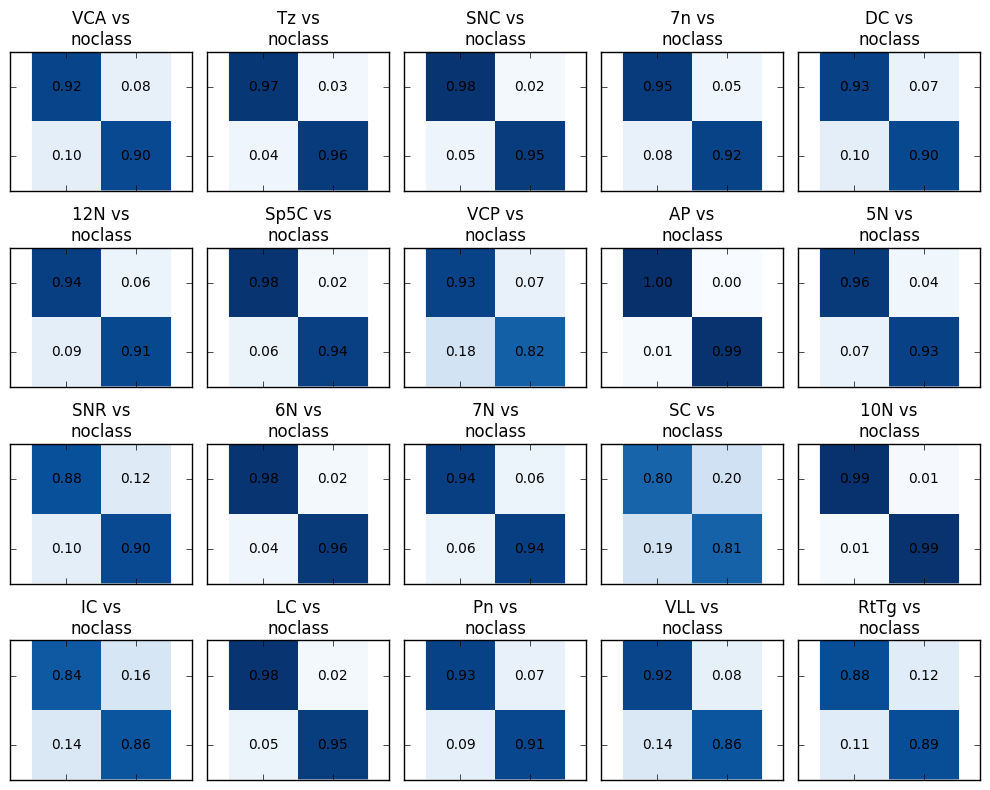

In [20]:
# Compute x vs. noclass accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(existing_names)/float(ncols)))


fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

# for i, label in enumerate(structures):
for i, label in enumerate(existing_names):
    
    features_pos = test_features[label]
    n_pos = len(features_pos)
    
#     features_neg = test_features[convert_to_surround_name(label)]
    
#     if train_sample_scheme in [1,3,4,5,6,7]:
#         features_neg = test_features[convert_to_surround_name(label, 'noclass')]
#     elif train_sample_scheme == 2:
#         features_neg = np.vstack([test_features[convert_to_surround_name(label, 'noclass')]] + \
#                                   [test_features[convert_to_surround_name(label, surr_l)] 
#                                   for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
# #     elif train_sample_scheme == 8:
    features_neg = test_features['noclass']
    n_neg = len(features_neg)
#         features_neg = test_features['7N']
#     else:
#         sys.stderr.write('training scheme is not recognized.\n')
        
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    plot_confusion_matrix(cm, title='%(label)s vs\nnoclass'% {'label':label},
                          labels=['',''], xlabel='', ylabel='',
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc
    
plt.tight_layout()

In [ ]:
print 'test accuracy:', np.mean(acc_all_structures.values())

In [ ]:
single_vs_noclass_cm_plot_fp = os.path.join(plots_dir, 'single_vs_noclass_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute surround accuracy

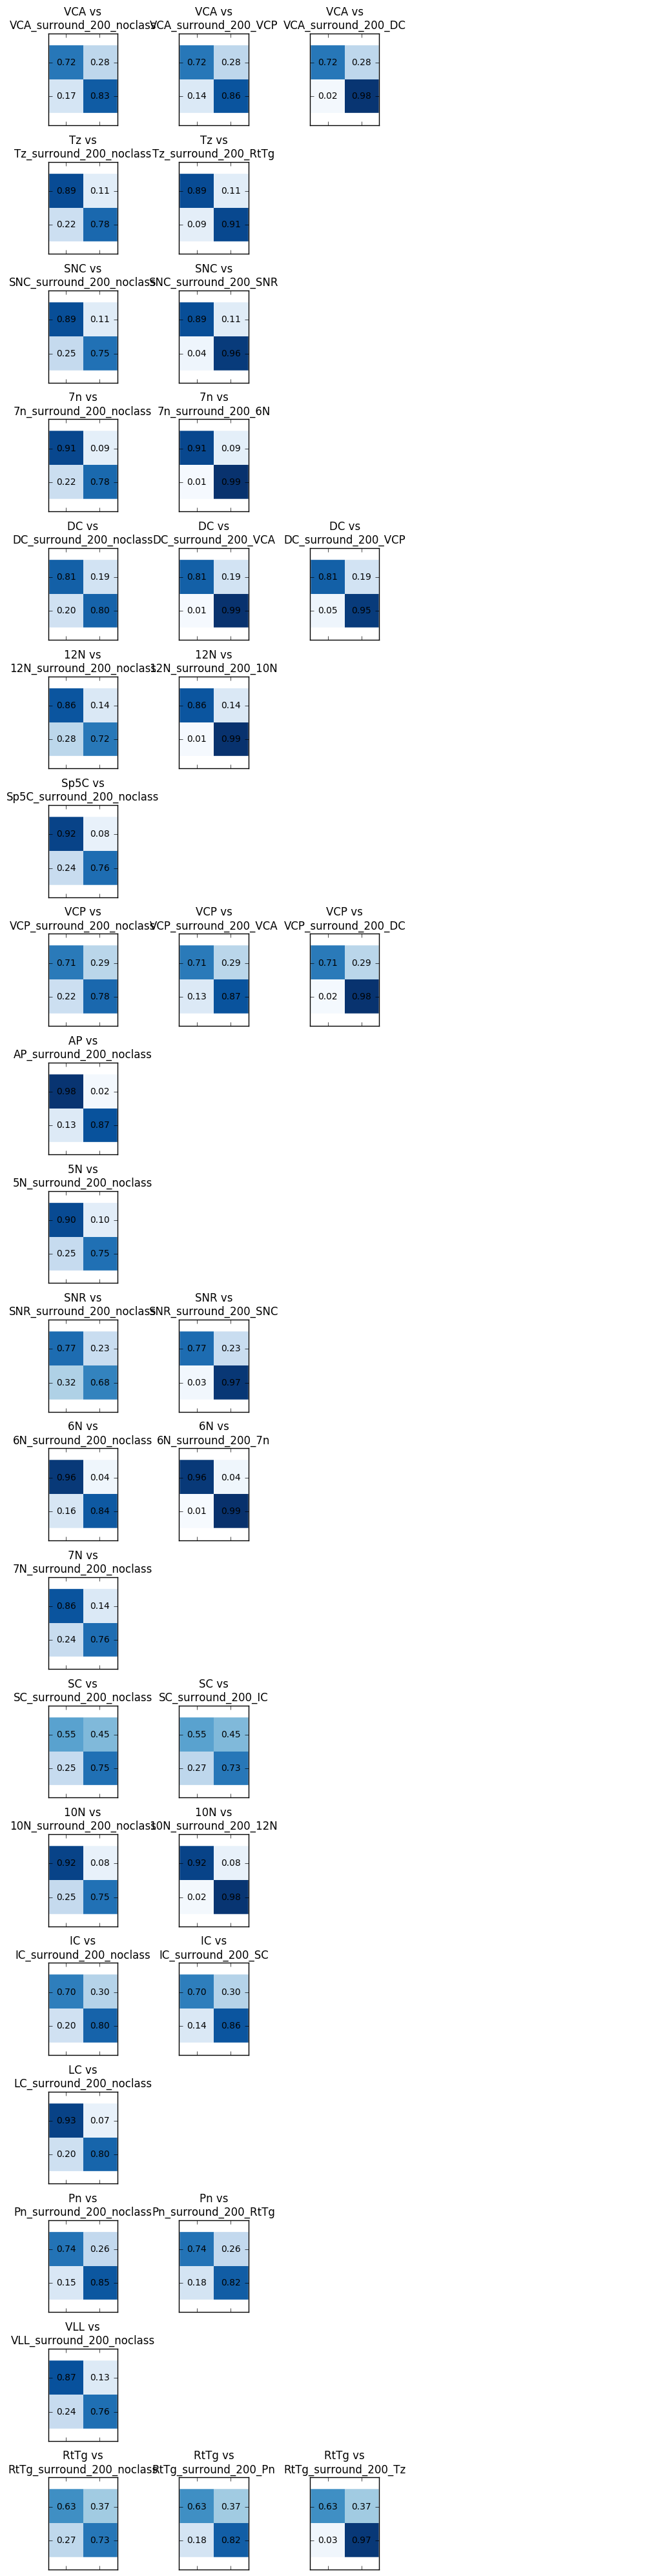

In [49]:
# Compute surround accuracy

margin = 200
acc_all_pairs = {}

ncols = 5
nrows = len(existing_names)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)

for i, label in enumerate(existing_names):
#     print label

    features_pos = test_features[label]
    n_pos = len(features_pos)

    neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(label, margin=margin, suffix=surr_l) 
     for surr_l in structures if convert_to_surround_name(label, margin=margin, suffix=surr_l) in labels]

    for j, neg_class in enumerate(neg_classes):
#         print 'comparing with', neg_class

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        svc = svc_allClasses[label]

        probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)
        
        plot_confusion_matrix(cm, title='%(label)s vs\n%(neg_class)s'% {'label':label, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])
        
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                      normalize=False)
        acc = (cm[0,0]+cm[1,1]) / (n_pos+n_neg)
        acc_all_pairs['%(label)s vs %(neg_class)s'% {'label':label, 'neg_class': neg_class}] = acc


    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [ ]:
surround_cm_plot_fp = os.path.join(plots_dir, 'surround_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [50]:
print np.mean(acc_all_pairs.values())

0.803307092914


In [51]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('RtTg vs RtTg_surround_200_Tz', 0.63427977608062591),
 ('SC vs SC_surround_200_IC', 0.63821114160196457),
 ('SC vs SC_surround_200_noclass', 0.65214102929905915),
 ('RtTg vs RtTg_surround_200_noclass', 0.68183866344255062),
 ('RtTg vs RtTg_surround_200_Pn', 0.69421942695995287),
 ('VCP vs VCP_surround_200_DC', 0.71897936463582035),
 ('SNR vs SNR_surround_200_noclass', 0.72265090061928183),
 ('VCA vs VCA_surround_200_DC', 0.72429485358904144),
 ('VCP vs VCP_surround_200_noclass', 0.74673574271394594),
 ('IC vs IC_surround_200_noclass', 0.75039912461297309),
 ('VCP vs VCP_surround_200_VCA', 0.75997638902280984),
 ('VCA vs VCA_surround_200_VCP', 0.76314698955412763),
 ('Pn vs Pn_surround_200_RtTg', 0.76732817243757545),
 ('VCA vs VCA_surround_200_noclass', 0.77634417429783087),
 ('IC vs IC_surround_200_SC', 0.77769695019443841),
 ('12N vs 12N_surround_200_noclass', 0.78828382717620593),
 ('Pn vs Pn_surround_200_noclass', 0.79522924660850036),
 ('DC vs DC_surround_200_noclass', 0.8087624

# Compute surround accuracy for different margins

In [52]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in [100,200,300,400,500,600,700,800,900,1000]:
    
    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, label in enumerate(existing_names):
    #     print label

        features_pos = test_features[label]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(label, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(label, margin=margin, suffix=surr_l) for surr_l in structures if convert_to_surround_name(label, margin=margin, suffix=surr_l) in labels]

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]
            
            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            svc = svc_allClasses[label]

            probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(label)s vs %(neg_class)s'% {'label':label, 'neg_class': neg_class}] = acc
            
    acc_all_margins[margin] = acc_all_pairs

margin = 100
margin = 200
margin = 300
margin = 400
margin = 500
margin = 600
margin = 700
margin = 800
margin = 900
margin = 1000


In [55]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

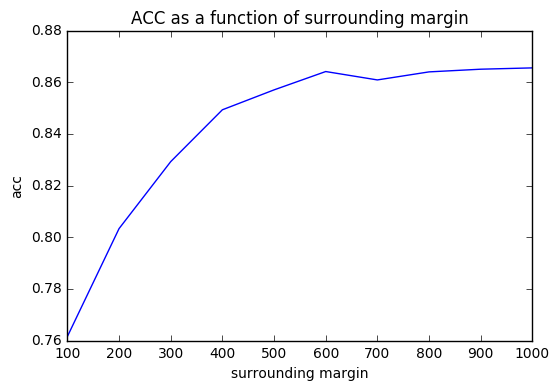

In [56]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute pairwise accuracy

In [27]:
# Compute pairwise accuracy

pairwise_cm = np.zeros((len(existing_names), len(existing_names)))

# for i, label in enumerate(structures):
# axes_id = 0
for i, label in enumerate(sorted(list(existing_names))):
    print i, label
    
    features_pos = test_features[label]
    n_pos = len(features_pos)
        
    for j, label2 in enumerate(sorted(list(existing_names))):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
        print 'comparing with', j, label2
        
        features_neg = test_features[label2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        svc = svc_allClasses[label]

        probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

0 10N
comparing with 1 12N
comparing with 2 5N
comparing with 3 6N
comparing with 4 7N
comparing with 5 7n
comparing with 6 AP
comparing with 7 DC
comparing with 8 IC
comparing with 9 LC
comparing with 10 Pn
comparing with 11 RtTg
comparing with 12 SC
comparing with 13 SNC
comparing with 14 SNR
comparing with 15 Sp5C
comparing with 16 Tz
comparing with 17 VCA
comparing with 18 VCP
comparing with 19 VLL
1 12N
comparing with 2 5N
comparing with 3 6N
comparing with 4 7N
comparing with 5 7n
comparing with 6 AP
comparing with 7 DC
comparing with 8 IC
comparing with 9 LC
comparing with 10 Pn
comparing with 11 RtTg
comparing with 12 SC
comparing with 13 SNC
comparing with 14 SNR
comparing with 15 Sp5C
comparing with 16 Tz
comparing with 17 VCA
comparing with 18 VCP
comparing with 19 VLL
2 5N
comparing with 3 6N
comparing with 4 7N
comparing with 5 7n
comparing with 6 AP
comparing with 7 DC
comparing with 8 IC
comparing with 9 LC
comparing with 10 Pn
comparing with 11 RtTg
comparing with 12 SC

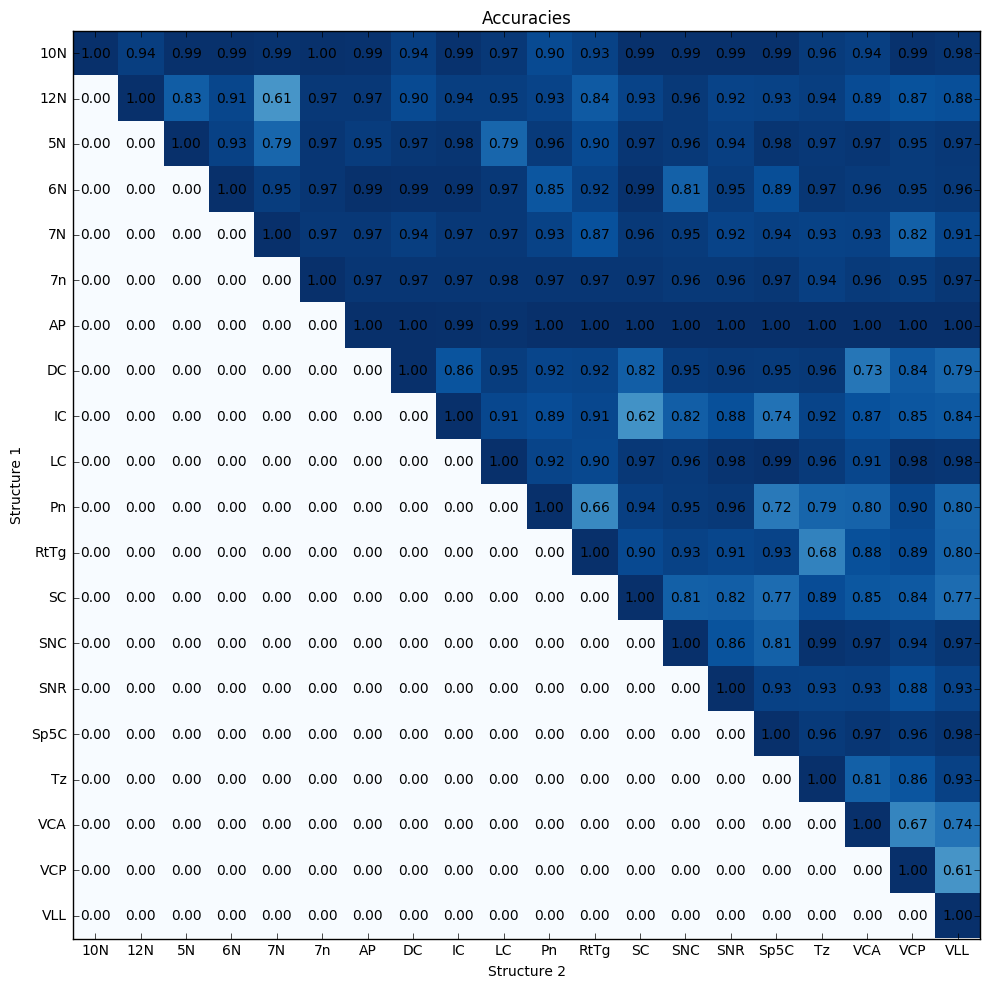

In [28]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=sorted(list(existing_names)),
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [ ]:
pariwise_cm_plot_fp = os.path.join(plots_dir, 'pairwise_cm_trainSampleScheme_%d.png' % train_sample_scheme)
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')